# LSTM Time-CNN-BiLSTM-DA Training

**Entrenamiento exploratorio de Time-CNN-BiLSTM con Domain Adaptation para clasificación de Parkinson**

## Arquitectura

- **Time-distributed CNN**: Extracción de features por frame
- **BiLSTM**: Modelado temporal de secuencias
- **Attention Pooling**: Agregación temporal con masking
- **Dual-head**: Clasificación PD + Domain Adaptation con GRL

## Referencias

Ibarra et al. (2023) "Towards a Corpus (and Language)-Independent Screening of Parkinson's Disease from Voice and Speech through Domain Adaptation"


In [1]:
# ============================================================
# IMPORTS Y CONFIGURACIÓN
# ============================================================

import sys
from pathlib import Path

# Agregar directorio raíz al path
sys.path.insert(0, str(Path.cwd()))

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Imports propios
from modules.core.sequence_dataset import create_sequence_dataset_from_cache
from modules.models.lstm_da.model import TimeCNNBiLSTM_DA, print_model_summary
from modules.models.lstm_da.training import (
    train_one_epoch_da, validate_epoch_da, grl_lambda
)
from modules.models.lstm_da.visualization import (
    plot_training_curves_da, plot_lstm_attention_weights
)

print("Imports completados")
print(f"PyTorch version: {torch.__version__}")
print(f"Device disponible: {'CUDA' if torch.cuda.is_available() else 'CPU'}")


Imports completados
PyTorch version: 2.8.0+cpu
Device disponible: CPU


In [2]:
# ============================================================
# CONFIGURACIÓN DE HIPERPARÁMETROS
# ============================================================

# Configuración del experimento
CONFIG = {
    # Datos
    "n_frames": 7,  # Número de frames por secuencia
    "cache_dir": "cache/sequences",
    
    # Modelo (según Ibarra et al. 2023)
    "lstm_units": 64,  # Unidades LSTM por dirección
    "n_domains": 4,  # Número de dominios (GITA, Neurovoz, German, Czech)
    "dropout_conv": 0.3,
    "dropout_fc": 0.5,
    
    # Entrenamiento
    "batch_size": 32,
    "lr": 0.1,  # Learning rate inicial (SGD)
    "momentum": 0.9,
    "weight_decay": 1e-4,
    "alpha": 1.0,  # Peso de pérdida de dominio
    "lambda_warmup_epochs": 5,  # Épocas para warm-up GRL
    "step_size": 30,  # Decay LR cada 30 épocas
    "gamma": 0.1,  # Factor de decay LR
    
    # Validación
    "n_folds": 5,  # Para K-fold CV
    "patience": 15,  # Early stopping
    "max_epochs": 100,
    
    # Device
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}

print("CONFIGURACIÓN:")
for key, value in CONFIG.items():
    print(f"   {key}: {value}")

# Semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)
print(f"\nSemilla fijada: 42")


CONFIGURACIÓN:
   n_frames: 7
   cache_dir: cache/sequences
   lstm_units: 64
   n_domains: 4
   dropout_conv: 0.3
   dropout_fc: 0.5
   batch_size: 32
   lr: 0.1
   momentum: 0.9
   weight_decay: 0.0001
   alpha: 1.0
   lambda_warmup_epochs: 5
   step_size: 30
   gamma: 0.1
   n_folds: 5
   patience: 15
   max_epochs: 100
   device: cpu

Semilla fijada: 42


In [3]:
# ============================================================
# GENERACIÓN Y CARGA DE SECUENCIAS LSTM
# ============================================================

print("="*70)
print("GENERACIÓN Y CARGA DE SECUENCIAS LSTM")
print("="*70)

# Paths de cache de secuencias
n_frames = CONFIG["n_frames"]
cache_dir = Path(CONFIG["cache_dir"])
healthy_cache = cache_dir / f"healthy_n{n_frames}.pkl"
parkinson_cache = cache_dir / f"parkinson_n{n_frames}.pkl"

print(f"\nVerificando secuencias (n={n_frames})...")
print(f"   HC: {healthy_cache}")
print(f"   PD: {parkinson_cache}")

# Verificar si existen los caches, si no, generarlos
if not healthy_cache.exists() or not parkinson_cache.exists():
    print(f"\nCaches no encontrados. Generando secuencias automáticamente...")
    
    # Importar funciones de generación
    from modules.core.dataset import load_spectrograms_cache
    from modules.core.sequence_dataset import (
        group_spectrograms_to_sequences,
        save_sequence_cache,
        print_sequence_stats,
    )
    
    # Crear directorio de secuencias
    cache_dir.mkdir(parents=True, exist_ok=True)
    
    # Generar secuencias para Healthy (usando datos ORIGINALES, sin augmentation)
    if not healthy_cache.exists():
        print(f"\nGenerando secuencias Healthy...")
        healthy_original = Path("cache/original/healthy_ibarra.pkl")
        if healthy_original.exists():
            dataset = load_spectrograms_cache(str(healthy_original))
            sequences, lengths, metadata = group_spectrograms_to_sequences(
                dataset=dataset,
                n_frames=n_frames,
                min_frames=3,
                normalize=False,
            )
            save_sequence_cache(sequences, lengths, metadata, str(healthy_cache))
            print_sequence_stats(sequences, lengths, f"Healthy n={n_frames}")
        else:
            raise FileNotFoundError(f"Cache original no encontrado: {healthy_original}")
    
    # Generar secuencias para Parkinson (usando datos ORIGINALES, sin augmentation)
    if not parkinson_cache.exists():
        print(f"\nGenerando secuencias Parkinson...")
        parkinson_original = Path("cache/original/parkinson_ibarra.pkl")
        if parkinson_original.exists():
            dataset = load_spectrograms_cache(str(parkinson_original))
            sequences, lengths, metadata = group_spectrograms_to_sequences(
                dataset=dataset,
                n_frames=n_frames,
                min_frames=3,
                normalize=False,
            )
            save_sequence_cache(sequences, lengths, metadata, str(parkinson_cache))
            print_sequence_stats(sequences, lengths, f"Parkinson n={n_frames}")
        else:
            raise FileNotFoundError(f"Cache original no encontrado: {parkinson_original}")
    
    print(f"\nSecuencias generadas exitosamente")

# Cargar datasets
print(f"\nCargando secuencias Healthy...")
hc_dataset = create_sequence_dataset_from_cache(
    cache_path=str(healthy_cache),
    label_value=0,  # HC
)

print(f"\nCargando secuencias Parkinson...")
pd_dataset = create_sequence_dataset_from_cache(
    cache_path=str(parkinson_cache),
    label_value=1,  # PD
)

# Combinar datasets
combined_dataset = ConcatDataset([hc_dataset, pd_dataset])

print(f"\nDataset combinado: {len(combined_dataset)} secuencias")
print(f"   HC: {len(hc_dataset)} secuencias")
print(f"   PD: {len(pd_dataset)} secuencias")

# Verificar balance
hc_pct = len(hc_dataset) / len(combined_dataset) * 100
pd_pct = len(pd_dataset) / len(combined_dataset) * 100
print(f"   Balance: HC {hc_pct:.1f}% | PD {pd_pct:.1f}%")


GENERACIÓN Y CARGA DE SECUENCIAS LSTM

Verificando secuencias (n=7)...
   HC: cache\sequences\healthy_n7.pkl
   PD: cache\sequences\parkinson_n7.pkl

Cargando secuencias Healthy...
✅ Cache cargado: cache\sequences\healthy_n7.pkl
   Secuencias: 10

Cargando secuencias Parkinson...
✅ Cache cargado: cache\sequences\parkinson_n7.pkl
   Secuencias: 5

Dataset combinado: 15 secuencias
   HC: 10 secuencias
   PD: 5 secuencias
   Balance: HC 66.7% | PD 33.3%



VISUALIZACIÓN DE SECUENCIAS GENERADAS
✅ Función importada desde módulo

VISUALIZANDO SECUENCIAS HEALTHY

Visualizando ejemplos de Healthy...



Healthy Ejemplo 1 (idx=8):
   Subject: 739
   Vowel: iau
   Filename: 739-iau-egg.egg
   Length: 7/7 frames
   Shape: (7, 1, 65, 41)
   Mean: 0.0000
   Std: 1.0000
   Padding: 0.0000 (debe ser ~0)

Healthy Ejemplo 2 (idx=1):
   Subject: 1121
   Vowel: u_h
   Filename: 1121-u_h-egg.egg
   Length: 6/7 frames
   Shape: (7, 1, 65, 41)
   Mean: 0.0000
   Std: 1.0000
   Padding: 0.0000 (debe ser ~0)

Healthy Ejemplo 3 (idx=5):
   Subject: 1542
   Vowel: i_h
   Filename: 1542-i_h-egg.egg
   Length: 6/7 frames
   Shape: (7, 1, 65, 41)
   Mean: -0.0000
   Std: 1.0000
   Padding: 0.0000 (debe ser ~0)


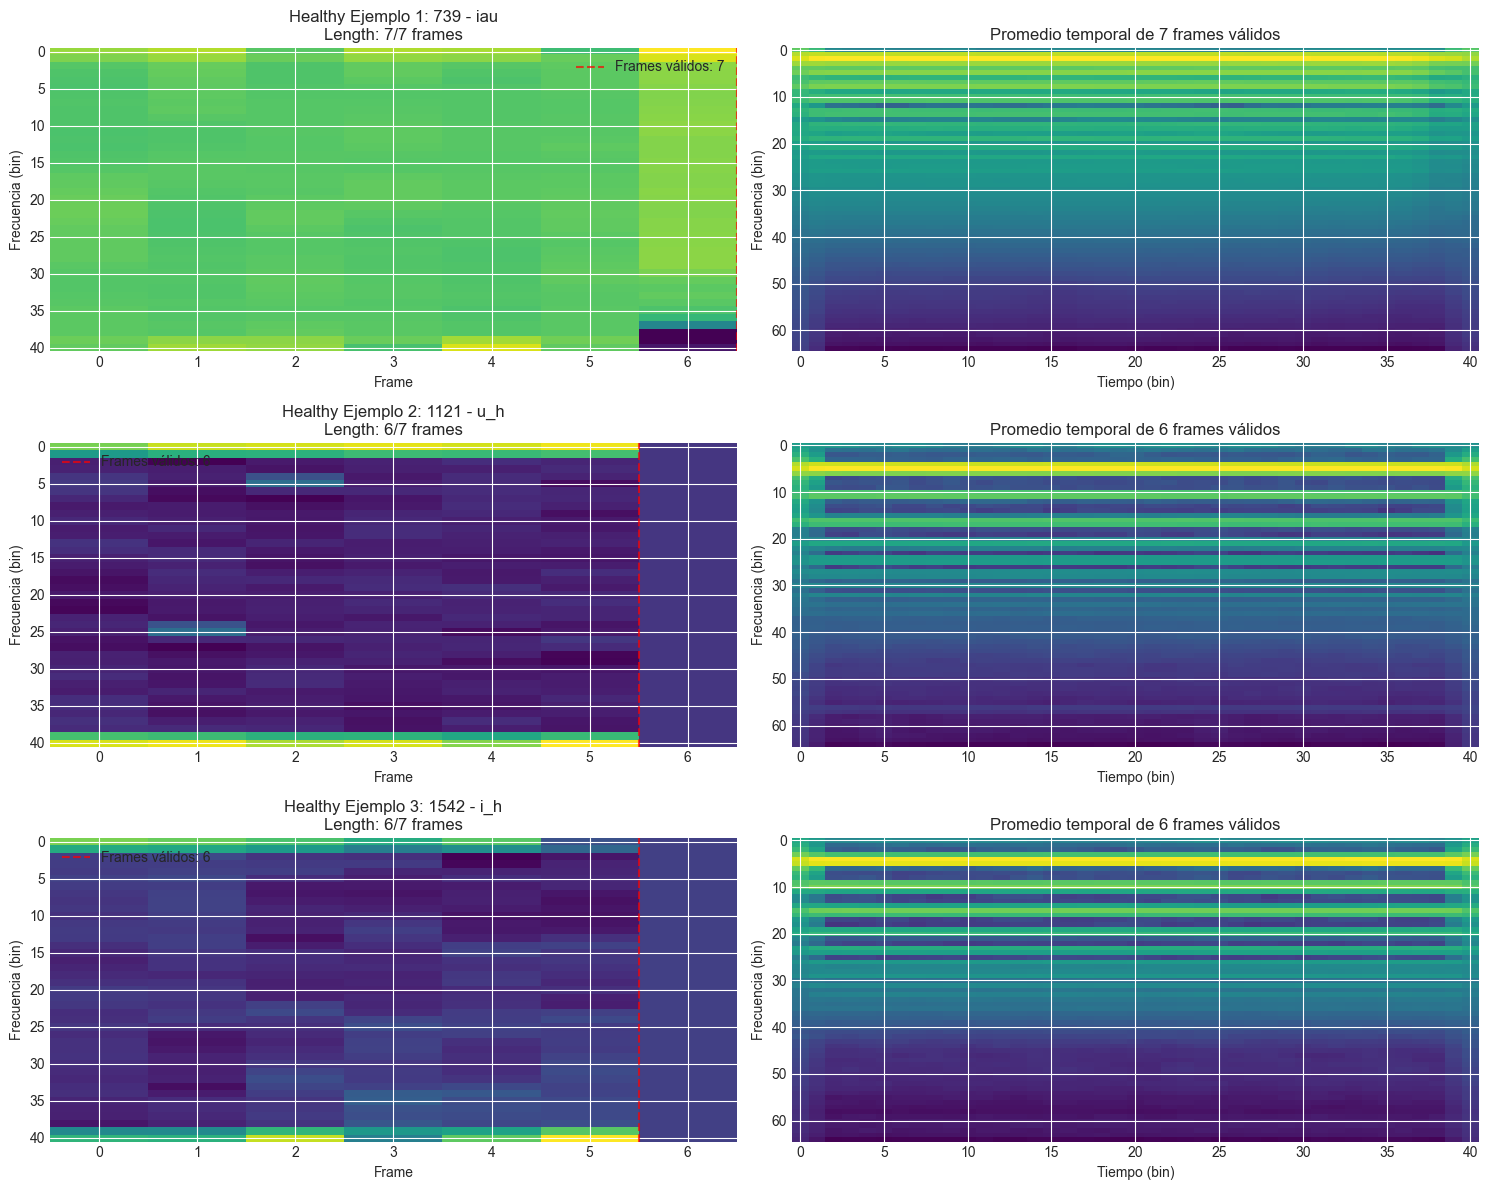


VISUALIZANDO SECUENCIAS PARKINSON

Visualizando ejemplos de Parkinson...

Parkinson Ejemplo 1 (idx=1):
   Subject: 1580
   Vowel: iau
   Filename: 1580-iau-egg.egg
   Length: 7/7 frames
   Shape: (7, 1, 65, 41)
   Mean: -0.0000
   Std: 1.0000
   Padding: 0.0000 (debe ser ~0)

Parkinson Ejemplo 2 (idx=0):
   Subject: 1580
   Vowel: a_lhl
   Filename: 1580-a_lhl-egg.egg
   Length: 3/7 frames
   Shape: (7, 1, 65, 41)
   Mean: -0.0000
   Std: 1.0000
   Padding: 0.0000 (debe ser ~0)

Parkinson Ejemplo 3 (idx=3):
   Subject: 1580
   Vowel: i_n
   Filename: 1580-i_n-egg.egg
   Length: 3/7 frames
   Shape: (7, 1, 65, 41)
   Mean: -0.0000
   Std: 1.0000
   Padding: 0.0000 (debe ser ~0)


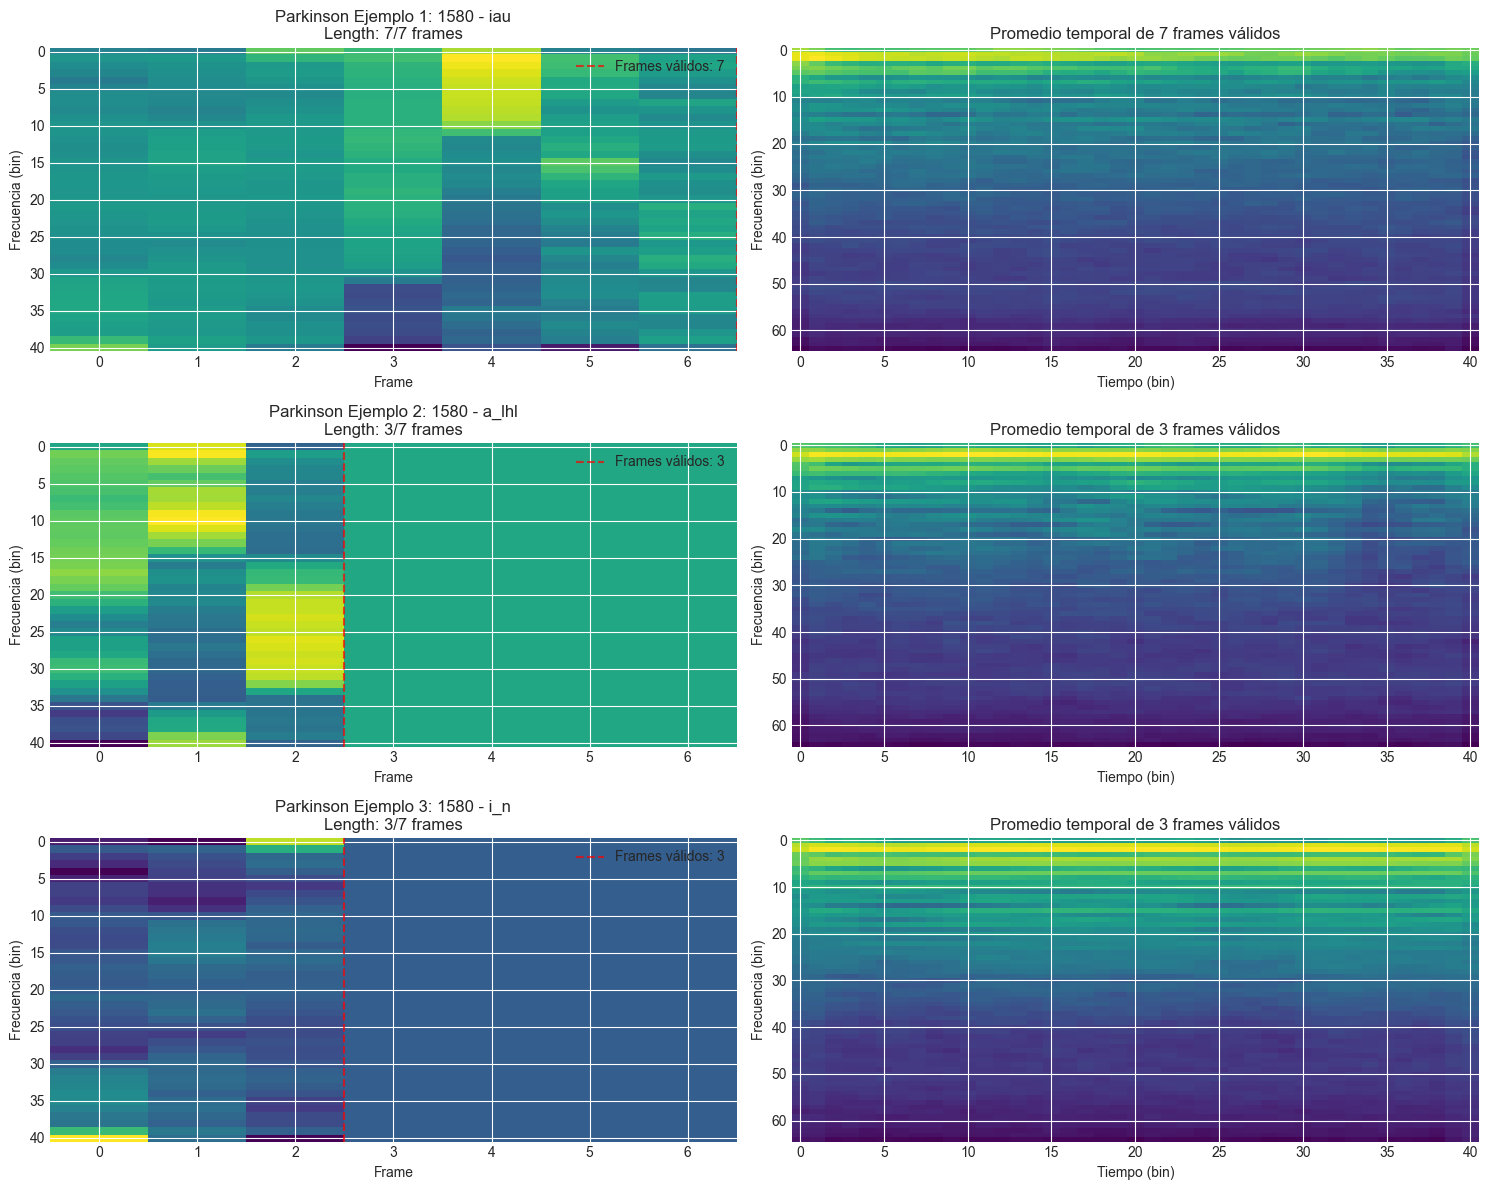


ESTADÍSTICAS GENERALES:
   Total secuencias: 15
   HC: 10 secuencias
   PD: 5 secuencias

Verificaciones:
   HC shape correcto: True
   PD shape correcto: True
   HC label correcto: True
   PD label correcto: True
   HC length <= 7: True
   PD length <= 7: True

Visualización completada
Verificaciones:
   • Secuencias tienen shape (7, 1, 65, 41)
   • Padding está en cero (frames > length)
   • Frames válidos tienen valores normalizados
   • Longitudes varían según archivo de audio
   • Metadata preservada correctamente


In [4]:
# ============================================================
# VISUALIZACIÓN DE SECUENCIAS GENERADAS
# ============================================================

print("\n" + "="*70)
print("VISUALIZACIÓN DE SECUENCIAS GENERADAS")
print("="*70)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Recargar módulo para asegurar que tenemos la versión más reciente
import importlib
import modules.models.lstm_da.visualization
importlib.reload(modules.models.lstm_da.visualization)

# Importar función de visualización del módulo
try:
    from modules.models.lstm_da.visualization import visualize_sequence_examples
    print("✅ Función importada desde módulo")
except ImportError as e:
    print(f"⚠️  Error importando desde módulo: {e}")
    print("Definiendo función localmente...")
    
    def visualize_sequence_examples(dataset, dataset_name: str, n_examples: int = 3):
        """Visualiza ejemplos de secuencias LSTM."""
        print(f"\nVisualizando ejemplos de {dataset_name}...")
        
        # Seleccionar ejemplos aleatorios
        n_examples = min(n_examples, len(dataset))
        indices = np.random.choice(len(dataset), n_examples, replace=False)
        
        # Crear figura
        fig, axes = plt.subplots(n_examples, 2, figsize=(15, 4 * n_examples))
        if n_examples == 1:
            axes = axes.reshape(1, -1)
        
        for i, idx in enumerate(indices):
            sample = dataset[idx]
            sequence = sample["X"].numpy()
            length = sample["length"]
            meta = sample["meta"]
            
            # Visualizar secuencia completa (todos los frames)
            ax1 = axes[i, 0]
            
            # Crear imagen de la secuencia (T, H) promediando sobre canales y frecuencias
            sequence_2d = sequence[:, 0, :, :].mean(axis=1)  # (T, W)
            
            im1 = ax1.imshow(sequence_2d.T, aspect="auto", cmap="viridis")
            ax1.set_title(
                f"{dataset_name} Ejemplo {i + 1}: {meta.subject_id} - {meta.vowel_type}\n"
                f"Length: {length}/{sequence.shape[0]} frames"
            )
            ax1.set_xlabel("Frame")
            ax1.set_ylabel("Frecuencia (bin)")
            
            # Marcar frames válidos vs padding
            ax1.axvline(
                x=length - 0.5,
                color="red",
                linestyle="--",
                alpha=0.7,
                label=f"Frames válidos: {length}",
            )
            ax1.legend()
            
            # Visualizar solo frames válidos
            ax2 = axes[i, 1]
            valid_sequence = sequence[:length, 0, :, :]  # Solo frames válidos
            
            # Promedio temporal de frames válidos
            temporal_mean = valid_sequence.mean(axis=0)  # (H, W)
            
            im2 = ax2.imshow(temporal_mean, aspect="auto", cmap="viridis")
            ax2.set_title(f"Promedio temporal de {length} frames válidos")
            ax2.set_xlabel("Tiempo (bin)")
            ax2.set_ylabel("Frecuencia (bin)")
            
            # Estadísticas
            print(f"\n{dataset_name} Ejemplo {i + 1} (idx={idx}):")
            print(f"   Subject: {meta.subject_id}")
            print(f"   Vowel: {meta.vowel_type}")
            print(f"   Filename: {meta.filename}")
            print(f"   Length: {length}/{sequence.shape[0]} frames")
            print(f"   Shape: {sequence.shape}")
            print(f"   Mean: {sequence[:length].mean():.4f}")
            print(f"   Std: {sequence[:length].std():.4f}")
            print(f"   Padding: {sequence[length:].sum():.4f} (debe ser ~0)")
        
        plt.tight_layout()
        plt.show()

# Visualizar ejemplos de healthy
print("\nVISUALIZANDO SECUENCIAS HEALTHY")
visualize_sequence_examples(hc_dataset, "Healthy", n_examples=3)

# Visualizar ejemplos de parkinson
print("\nVISUALIZANDO SECUENCIAS PARKINSON")
visualize_sequence_examples(pd_dataset, "Parkinson", n_examples=3)

# Estadísticas generales
print(f"\nESTADÍSTICAS GENERALES:")
print(f"   Total secuencias: {len(combined_dataset)}")
print(f"   HC: {len(hc_dataset)} secuencias")
print(f"   PD: {len(pd_dataset)} secuencias")

# Verificar shapes
sample_hc = hc_dataset[0]
sample_pd = pd_dataset[0]
print(f"\nVerificaciones:")
print(f"   HC shape correcto: {sample_hc['X'].shape == (7, 1, 65, 41)}")
print(f"   PD shape correcto: {sample_pd['X'].shape == (7, 1, 65, 41)}")
print(f"   HC label correcto: {sample_hc['y_task'] == 0}")
print(f"   PD label correcto: {sample_pd['y_task'] == 1}")
print(f"   HC length <= 7: {sample_hc['length'] <= 7}")
print(f"   PD length <= 7: {sample_pd['length'] <= 7}")

print(f"\nVisualización completada")
print("Verificaciones:")
print("   • Secuencias tienen shape (7, 1, 65, 41)")
print("   • Padding está en cero (frames > length)")
print("   • Frames válidos tienen valores normalizados")
print("   • Longitudes varían según archivo de audio")
print("   • Metadata preservada correctamente")


In [5]:
# ============================================================
# PREPARACIÓN DE DATOS PARA K-FOLD
# ============================================================

print("\n" + "="*70)
print("PREPARACIÓN DE DATOS PARA K-FOLD")
print("="*70)

# Extraer metadata para K-fold speaker-independent
metadata_list = []

# Metadata HC (label=0)
for i in range(len(hc_dataset)):
    sample = hc_dataset[i]
    meta = sample["meta"]
    metadata_list.append({
        "subject_id": meta.subject_id,
        "filename": meta.filename,
        "label": 0,
        "domain_label": sample["y_domain"],
    })

# Metadata PD (label=1)
for i in range(len(pd_dataset)):
    sample = pd_dataset[i]
    meta = sample["meta"]
    metadata_list.append({
        "subject_id": meta.subject_id,
        "filename": meta.filename,
        "label": 1,
        "domain_label": sample["y_domain"],
    })

print(f"\nMetadata preparada: {len(metadata_list)} secuencias")

# Verificar balance
hc_count = sum(1 for m in metadata_list if m["label"] == 0)
pd_count = sum(1 for m in metadata_list if m["label"] == 1)
hc_pct = hc_count / len(metadata_list) * 100
pd_pct = pd_count / len(metadata_list) * 100
print(f"   HC: {hc_count} ({hc_pct:.1f}%)")
print(f"   PD: {pd_count} ({pd_pct:.1f}%)")

# Contar subjects únicos
unique_subjects = set(m["subject_id"] for m in metadata_list)
print(f"\nSubjects únicos: {len(unique_subjects)}")

# Contar dominios únicos
unique_domains = set(m["domain_label"] for m in metadata_list)
print(f"Dominios únicos: {len(unique_domains)}")

# Verificar que tenemos suficientes subjects para K-fold
n_folds = CONFIG["n_folds"]
if len(unique_subjects) < n_folds:
    print(f"ADVERTENCIA: Solo {len(unique_subjects)} subjects para {n_folds} folds")
    print(f"   Reduciendo folds a {len(unique_subjects)}")
    CONFIG["n_folds"] = len(unique_subjects)



PREPARACIÓN DE DATOS PARA K-FOLD

Metadata preparada: 15 secuencias
   HC: 10 (66.7%)
   PD: 5 (33.3%)

Subjects únicos: 11
Dominios únicos: 3


In [6]:
# ============================================================
# CREACIÓN DEL MODELO
# ============================================================

print("\n" + "="*70)
print("CREACIÓN DEL MODELO TIME-CNN-BILSTM-DA")
print("="*70)

# Parámetros del modelo
model_params = {
    "n_frames": CONFIG["n_frames"],
    "lstm_units": CONFIG["lstm_units"],
    "n_domains": CONFIG["n_domains"],
    "p_drop_conv": CONFIG["dropout_conv"],
    "p_drop_fc": CONFIG["dropout_fc"],
}

print("\nParámetros del modelo:")
for key, value in model_params.items():
    print(f"   {key}: {value}")

# Crear modelo
model = TimeCNNBiLSTM_DA(**model_params)
model = model.to(CONFIG["device"])

print(f"\nResumen del modelo:")
print_model_summary(model)

# Verificar input shape
print(f"\nVerificación de input shape:")
sample_batch = torch.randn(2, CONFIG["n_frames"], 1, 65, 41).to(CONFIG["device"])
sample_lengths = torch.tensor([CONFIG["n_frames"], CONFIG["n_frames"]-1]).to(CONFIG["device"])

print(f"   Input shape: {sample_batch.shape}")
print(f"   Lengths: {sample_lengths}")

with torch.no_grad():
    logits_pd, logits_domain, embeddings = model(
        sample_batch, 
        lengths=sample_lengths, 
        return_embeddings=True
    )

print(f"   Output PD shape: {logits_pd.shape}")
print(f"   Output Domain shape: {logits_domain.shape}")
print(f"   Embeddings shape: {embeddings.shape}")
print("Modelo creado correctamente")



CREACIÓN DEL MODELO TIME-CNN-BILSTM-DA

Parámetros del modelo:
   n_frames: 7
   lstm_units: 64
   n_domains: 4
   p_drop_conv: 0.3
   p_drop_fc: 0.5

Resumen del modelo:

RESUMEN DEL MODELO TIME-CNN-BILSTM-DA
TimeCNNBiLSTM_DA(
  (feature_extractor): FeatureExtractor(
    (block1): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.3, inplace=False)
    )
    (block2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.3, inplace=False)
    )
  )
  (projec

In [7]:
# ============================================================
# K-FOLD CROSS-VALIDATION
# ============================================================

print("\n" + "="*70)
print("K-FOLD CROSS-VALIDATION")
print("="*70)

# Preparar K-fold speaker-independent
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold

# Extraer subject_ids y labels para stratified K-fold
subject_ids = []
labels = []
subject_to_indices = defaultdict(list)

for idx, meta in enumerate(metadata_list):
    subject_id = meta["subject_id"]
    label = meta["label"]
    
    subject_ids.append(subject_id)
    labels.append(label)
    subject_to_indices[subject_id].append(idx)

# Obtener unique subjects con sus labels
unique_subjects = list(subject_to_indices.keys())
subject_labels = []
for subj in unique_subjects:
    indices = subject_to_indices[subj]
    subj_label = labels[indices[0]]  # Asumir mismo label por sujeto
    subject_labels.append(subj_label)

print(f"\nSubjects para K-fold: {len(unique_subjects)}")
print(f"   HC subjects: {sum(1 for l in subject_labels if l == 0)}")
print(f"   PD subjects: {sum(1 for l in subject_labels if l == 1)}")

# Stratified K-Fold sobre subjects
skf = StratifiedKFold(n_splits=CONFIG["n_folds"], shuffle=True, random_state=42)

# Para este notebook, usaremos solo el primer fold para entrenamiento exploratorio
fold = 1
train_subjects_idx, val_subjects_idx = next(iter(skf.split(unique_subjects, subject_labels)))

# Obtener subject names
train_subjects = [unique_subjects[i] for i in train_subjects_idx]
val_subjects = [unique_subjects[i] for i in val_subjects_idx]

# Obtener índices de samples
train_indices = []
val_indices = []

for subj in train_subjects:
    train_indices.extend(subject_to_indices[subj])
for subj in val_subjects:
    val_indices.extend(subject_to_indices[subj])

print(f"\nDivisión de datos (Fold {fold}):")
print(f"   Train: {len(train_subjects)} subjects → {len(train_indices)} samples")
print(f"   Val:   {len(val_subjects)} subjects → {len(val_indices)} samples")

# Crear subsets
from torch.utils.data import Subset
train_dataset = Subset(combined_dataset, train_indices)
val_dataset = Subset(combined_dataset, val_indices)

print(f"\nDatasets creados:")
print(f"   Train dataset: {len(train_dataset)} samples")
print(f"   Val dataset: {len(val_dataset)} samples")



K-FOLD CROSS-VALIDATION

Subjects para K-fold: 11
   HC subjects: 10
   PD subjects: 1

División de datos (Fold 1):
   Train: 8 subjects → 8 samples
   Val:   3 subjects → 7 samples

Datasets creados:
   Train dataset: 8 samples
   Val dataset: 7 samples


c:\Users\fecor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [8]:
# ============================================================
# CONFIGURACIÓN DE ENTRENAMIENTO
# ============================================================

print("\n" + "="*70)
print("CONFIGURACIÓN DE ENTRENAMIENTO")
print("="*70)

# Función collate personalizada para manejar SampleMeta
def sequence_collate_fn(batch):
    """Collate function personalizada para secuencias LSTM con SampleMeta."""
    # Separar los diferentes tipos de datos
    X_list = []
    lengths_list = []
    y_task_list = []
    y_domain_list = []
    meta_list = []
    
    for sample in batch:
        X_list.append(sample["X"])
        lengths_list.append(sample["length"])
        y_task_list.append(sample["y_task"])
        y_domain_list.append(sample["y_domain"])
        meta_list.append(sample["meta"])
    
    # Convertir a tensors
    X = torch.stack(X_list)
    lengths = torch.tensor(lengths_list, dtype=torch.long)
    y_task = torch.tensor(y_task_list, dtype=torch.long)
    y_domain = torch.tensor(y_domain_list, dtype=torch.long)
    
    return {
        "X": X,
        "length": lengths,
        "y_task": y_task,
        "y_domain": y_domain,
        "meta": meta_list  # Mantener como lista de SampleMeta
    }

# DataLoaders con collate_fn personalizada
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=True,
    num_workers=0,
    collate_fn=sequence_collate_fn,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG["batch_size"],
    shuffle=False,
    num_workers=0,
    collate_fn=sequence_collate_fn,
)

print(f"\nDataLoaders creados:")
print(f"   Train loader: {len(train_loader)} batches (batch_size={CONFIG['batch_size']})")
print(f"   Val loader: {len(val_loader)} batches")

# Optimizer: SGD con momentum (según paper Ibarra 2023)
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=CONFIG["lr"],
    momentum=CONFIG["momentum"],
    weight_decay=CONFIG["weight_decay"],
)

# LR Scheduler: StepLR (decay cada 30 épocas según paper)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=CONFIG["step_size"],
    gamma=CONFIG["gamma"],
)

print(f"\nOptimizer configurado:")
print(f"   Type: SGD")
print(f"   LR inicial: {CONFIG['lr']}")
print(f"   Momentum: {CONFIG['momentum']}")
print(f"   Weight decay: {CONFIG['weight_decay']}")

print(f"\nScheduler configurado:")
print(f"   Type: StepLR")
print(f"   Step size: {CONFIG['step_size']} épocas")
print(f"   Gamma: {CONFIG['gamma']}")

# Class weights para PD task
train_labels_pd = [labels[i] for i in train_indices]
print(f"\nDebug - Train labels PD: {set(train_labels_pd)}")
print(f"Debug - Train labels PD counts: {np.bincount(train_labels_pd)}")

# Asegurar que tenemos ambas clases (0 y 1)
unique_labels = np.unique(train_labels_pd)
if len(unique_labels) < 2:
    print(f"⚠️  ADVERTENCIA: Solo {len(unique_labels)} clase(s) en train: {unique_labels}")
    print("   Usando pesos uniformes para evitar errores")
    class_weights_pd = torch.tensor([1.0, 1.0], dtype=torch.float32).to(CONFIG["device"])
else:
    class_counts = np.bincount(train_labels_pd, minlength=2)  # Asegurar 2 clases
    class_weights_pd = torch.tensor(
        [len(train_labels_pd) / (2 * c) if c > 0 else 1.0 for c in class_counts],
        dtype=torch.float32,
    ).to(CONFIG["device"])

# Class weights para domain task (4 dominios fijos)
train_labels_domain = [metadata_list[i].get("domain_label", 0) for i in train_indices]
print(f"\nDebug - Train labels domain: {set(train_labels_domain)}")
print(f"Debug - Train labels domain counts: {np.bincount(train_labels_domain)}")

# Asegurar que tenemos exactamente 4 dominios (0, 1, 2, 3)
domain_counts = np.bincount(train_labels_domain, minlength=4)  # Forzar 4 dominios
print(f"Debug - Domain counts (4 dominios): {domain_counts}")

# Manejar divisiones por cero y asegurar 4 elementos
class_weights_domain = torch.tensor(
    [len(train_labels_domain) / (4 * c) if c > 0 else 1.0 for c in domain_counts],
    dtype=torch.float32,
).to(CONFIG["device"])

# Verificar que tenemos exactamente 4 pesos
if class_weights_domain.shape[0] != 4:
    print(f"❌ ERROR: Domain weights debe tener 4 elementos, tiene {class_weights_domain.shape[0]}")
    print("   Usando pesos uniformes como fallback")
    class_weights_domain = torch.tensor([1.0, 1.0, 1.0, 1.0], dtype=torch.float32).to(CONFIG["device"])

print(f"\nClass weights:")
print(f"   PD weights shape: {class_weights_pd.shape}")
print(f"   PD weights: {class_weights_pd.cpu().numpy()}")
print(f"   Domain weights shape: {class_weights_domain.shape}")
print(f"   Domain weights: {class_weights_domain.cpu().numpy()}")

# Verificar que los pesos tienen la forma correcta
if class_weights_pd.shape[0] != 2:
    print(f"❌ ERROR: PD weights debe tener 2 elementos, tiene {class_weights_pd.shape[0]}")
    print("   Usando pesos uniformes como fallback")
    class_weights_pd = torch.tensor([1.0, 1.0], dtype=torch.float32).to(CONFIG["device"])

# Loss functions
criterion_pd = nn.CrossEntropyLoss(weight=class_weights_pd)
criterion_domain = nn.CrossEntropyLoss(weight=class_weights_domain)

print(f"\nLoss functions configuradas:")
print(f"   PD criterion: CrossEntropyLoss con class weights")
print(f"   Domain criterion: CrossEntropyLoss con class weights")
print(f"   Alpha (peso dominio): {CONFIG['alpha']}")

print(f"\nConfiguración de entrenamiento completada")



CONFIGURACIÓN DE ENTRENAMIENTO

DataLoaders creados:
   Train loader: 1 batches (batch_size=32)
   Val loader: 1 batches

Optimizer configurado:
   Type: SGD
   LR inicial: 0.1
   Momentum: 0.9
   Weight decay: 0.0001

Scheduler configurado:
   Type: StepLR
   Step size: 30 épocas
   Gamma: 0.1

Debug - Train labels PD: {0}
Debug - Train labels PD counts: [8]
⚠️  ADVERTENCIA: Solo 1 clase(s) en train: [0]
   Usando pesos uniformes para evitar errores

Debug - Train labels domain: {0, 1, 2}
Debug - Train labels domain counts: [3 2 3]
Debug - Domain counts (4 dominios): [3 2 3 0]

Class weights:
   PD weights shape: torch.Size([2])
   PD weights: [1. 1.]
   Domain weights shape: torch.Size([4])
   Domain weights: [0.6666667 1.        0.6666667 1.       ]

Loss functions configuradas:
   PD criterion: CrossEntropyLoss con class weights
   Domain criterion: CrossEntropyLoss con class weights
   Alpha (peso dominio): 1.0

Configuración de entrenamiento completada


In [9]:
# ============================================================
# ENTRENAMIENTO DEL MODELO
# ============================================================

print("\n" + "="*70)
print("ENTRENAMIENTO DEL MODELO")
print("="*70)

# Variables para tracking
best_val_loss = float("inf")
best_metrics = None
history = {"train": [], "val": []}

# Early stopping
from modules.models.cnn2d.training import EarlyStopping
early_stopping = EarlyStopping(patience=CONFIG["patience"], mode="min")

print(f"\nIniciando entrenamiento...")
print(f"   Máximo de épocas: {CONFIG['max_epochs']}")
print(f"   Early stopping patience: {CONFIG['patience']}")
print(f"   Lambda warm-up: {CONFIG['lambda_warmup_epochs']} épocas")

# Training loop
for epoch in range(CONFIG["max_epochs"]):
    # Train
    train_metrics = train_one_epoch_da(
        model=model,
        loader=train_loader,
        optimizer=optimizer,
        criterion_pd=criterion_pd,
        criterion_domain=criterion_domain,
        device=CONFIG["device"],
        alpha=CONFIG["alpha"],
        current_epoch=epoch,
        lambda_warmup_epochs=CONFIG["lambda_warmup_epochs"],
    )
    
    # Validate
    val_metrics = validate_epoch_da(
        model=model,
        loader=val_loader,
        criterion_pd=criterion_pd,
        criterion_domain=criterion_domain,
        device=CONFIG["device"],
        alpha=CONFIG["alpha"],
    )
    
    # Update scheduler
    scheduler.step()
    
    # Save history
    history["train"].append(train_metrics)
    history["val"].append(val_metrics)
    
    # Print progress
    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch {epoch+1:3d}/{CONFIG['max_epochs']} | "
            f"Train Loss: {train_metrics['loss_pd']:.4f} | "
            f"Val Loss: {val_metrics['loss_pd']:.4f} | "
            f"Val F1: {val_metrics['f1_pd']:.4f} | "
            f"λ: {train_metrics['lambda_grl']:.2f}"
        )
    
    # Early stopping
    if val_metrics["loss_pd"] < best_val_loss:
        best_val_loss = val_metrics["loss_pd"]
        best_metrics = val_metrics.copy()
    
    if early_stopping(val_metrics["loss_pd"], epoch):
        print(f"Early stopping en época {epoch+1}")
        break

print(f"\nEntrenamiento completado")
print(f"   Mejor val loss: {best_val_loss:.4f}")
print(f"   Mejor val F1: {best_metrics['f1_pd']:.4f}")
print(f"   Épocas entrenadas: {len(history['train'])}")



ENTRENAMIENTO DEL MODELO

Iniciando entrenamiento...
   Máximo de épocas: 100
   Early stopping patience: 15
   Lambda warm-up: 5 épocas
Epoch   5/100 | Train Loss: 0.0476 | Val Loss: 2.9522 | Val F1: 0.0000 | λ: 0.80
Epoch  10/100 | Train Loss: 0.0011 | Val Loss: 8.5613 | Val F1: 0.0000 | λ: 1.00
Epoch  15/100 | Train Loss: 0.0001 | Val Loss: 10.0924 | Val F1: 0.0000 | λ: 1.00
Early stopping en época 16

Entrenamiento completado
   Mejor val loss: 0.8175
   Mejor val F1: 0.0000
   Épocas entrenadas: 16


In [10]:
# ============================================================
# EVALUACIÓN Y MÉTRICAS
# ============================================================

print("\n" + "="*70)
print("EVALUACIÓN Y MÉTRICAS")
print("="*70)

# Evaluar en conjunto de validación
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for batch in val_loader:
        X = batch["X"].to(CONFIG["device"])
        lengths = batch["length"]
        if isinstance(lengths, list):
            lengths = torch.tensor(lengths, dtype=torch.long)
        lengths = lengths.to(CONFIG["device"])
        
        y_true = batch["y_task"]
        
        # Forward pass
        logits_pd, _, _ = model(X, lengths=lengths, return_embeddings=False)
        
        # Predicciones
        probs = torch.softmax(logits_pd, dim=1)
        preds = logits_pd.argmax(dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_true.numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # Probabilidad de PD

# Calcular métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=0)
recall = recall_score(all_labels, all_preds, zero_division=0)
f1 = f1_score(all_labels, all_preds, zero_division=0)

# Sensibilidad y especificidad
tn, fp, fn, tp = confusion_matrix(all_labels, all_preds, labels=[0,1]).ravel()
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall para PD
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # Recall para HC

print(f"\nMÉTRICAS DE RENDIMIENTO:")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   Sensibilidad (PD): {sensitivity:.4f}")
print(f"   Especificidad (HC): {specificity:.4f}")

print(f"\nMATRIZ DE CONFUSIÓN:")
print(f"   TN: {tn:3d} | FP: {fp:3d}")
print(f"   FN: {fn:3d} | TP: {tp:3d}")

# Reporte de clasificación
print(f"\nREPORTE DE CLASIFICACIÓN:")
report = classification_report(all_labels, all_preds, target_names=["HC", "PD"])
print(report)

print(f"\nEvaluación completada")



EVALUACIÓN Y MÉTRICAS

MÉTRICAS DE RENDIMIENTO:
   Accuracy:  0.2857
   Precision: 0.0000
   Recall:    0.0000
   F1-Score:  0.0000
   Sensibilidad (PD): 0.0000
   Especificidad (HC): 1.0000

MATRIZ DE CONFUSIÓN:
   TN:   2 | FP:   0
   FN:   5 | TP:   0

REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

          HC       0.29      1.00      0.44         2
          PD       0.00      0.00      0.00         5

    accuracy                           0.29         7
   macro avg       0.14      0.50      0.22         7
weighted avg       0.08      0.29      0.13         7


Evaluación completada


c:\Users\fecor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\fecor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\fecor\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave


VISUALIZACIÓN DE RESULTADOS

Generando curvas de entrenamiento...
Error en plot_training_curves_da: plot_training_curves_da() got an unexpected keyword argument 'show'


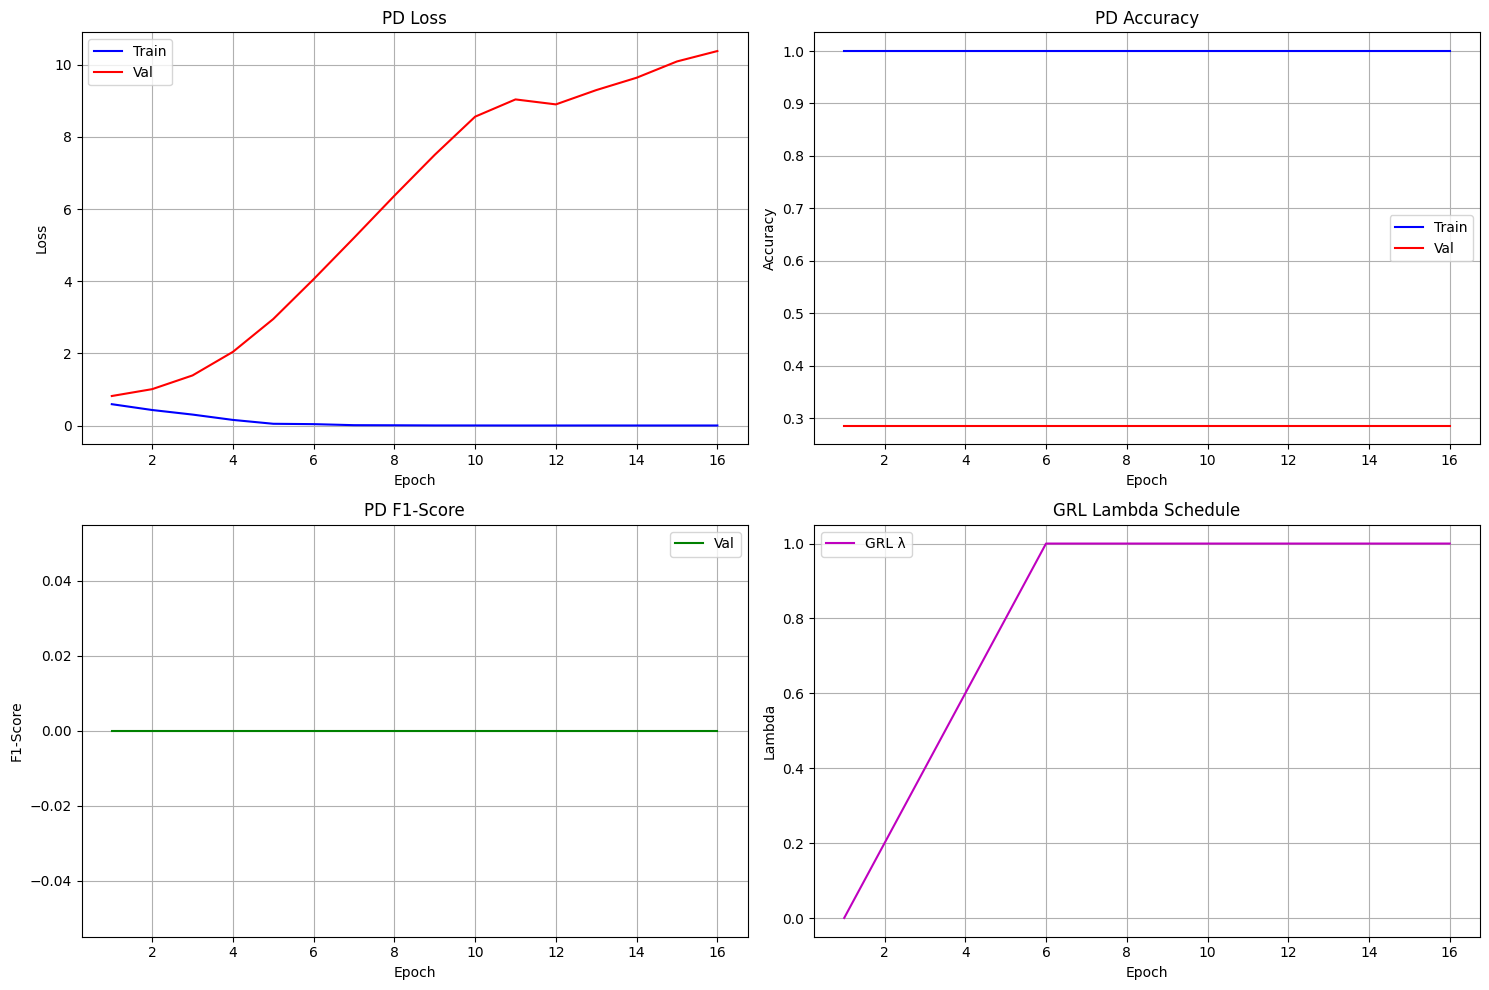


Generando matriz de confusión...


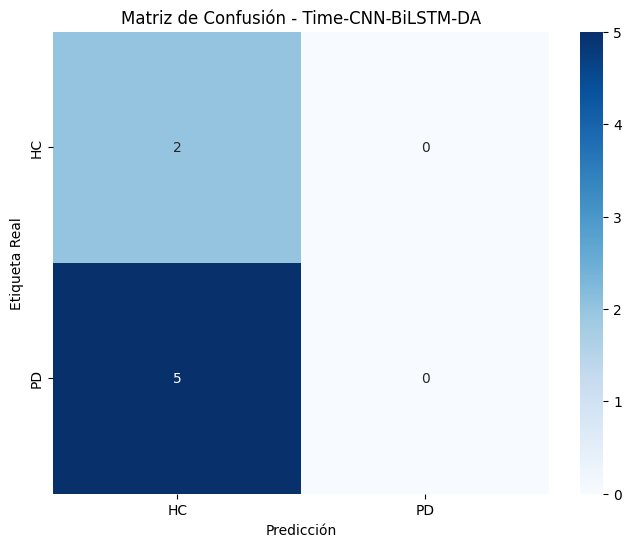


Generando histograma de probabilidades...


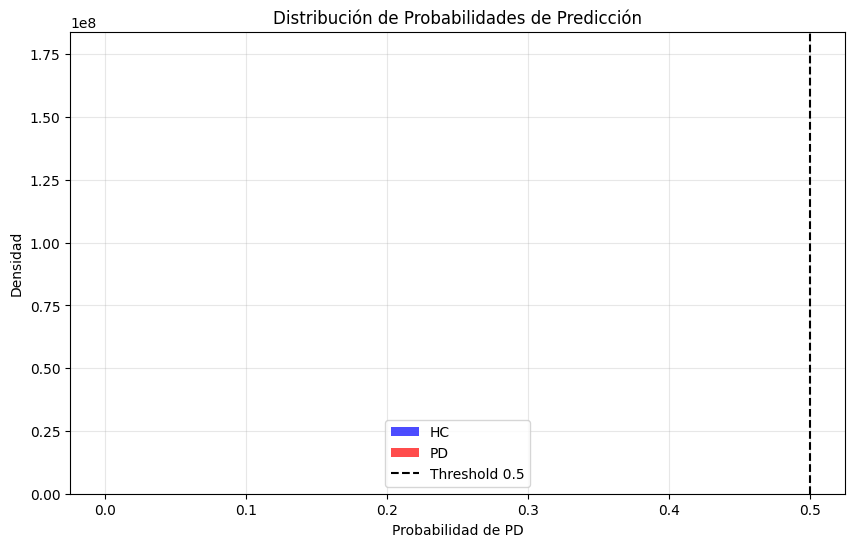


Visualizaciones completadas


In [11]:
# ============================================================
# VISUALIZACIÓN DE RESULTADOS
# ============================================================

print("\n" + "="*70)
print("VISUALIZACIÓN DE RESULTADOS")
print("="*70)

# Configurar estilo de plots
plt.style.use('default')
sns.set_palette("husl")

# 1. Curvas de entrenamiento
print("\nGenerando curvas de entrenamiento...")
try:
    plot_training_curves_da(history, save_path=None, show=True)
except Exception as e:
    print(f"Error en plot_training_curves_da: {e}")
    # Fallback: plot manual
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    epochs = range(1, len(history['train']) + 1)
    
    # Loss PD
    axes[0,0].plot(epochs, [h['loss_pd'] for h in history['train']], 'b-', label='Train')
    axes[0,0].plot(epochs, [h['loss_pd'] for h in history['val']], 'r-', label='Val')
    axes[0,0].set_title('PD Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].legend()
    axes[0,0].grid(True)
    
    # Accuracy PD
    axes[0,1].plot(epochs, [h['accuracy_pd'] for h in history['train']], 'b-', label='Train')
    axes[0,1].plot(epochs, [h['accuracy_pd'] for h in history['val']], 'r-', label='Val')
    axes[0,1].set_title('PD Accuracy')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Accuracy')
    axes[0,1].legend()
    axes[0,1].grid(True)
    
    # F1 PD
    axes[1,0].plot(epochs, [h['f1_pd'] for h in history['val']], 'g-', label='Val')
    axes[1,0].set_title('PD F1-Score')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('F1-Score')
    axes[1,0].legend()
    axes[1,0].grid(True)
    
    # Lambda GRL
    axes[1,1].plot(epochs, [h['lambda_grl'] for h in history['train']], 'm-', label='GRL λ')
    axes[1,1].set_title('GRL Lambda Schedule')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Lambda')
    axes[1,1].legend()
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()

# 2. Matriz de confusión
print("\nGenerando matriz de confusión...")
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'],
            ax=ax)
ax.set_title('Matriz de Confusión - Time-CNN-BiLSTM-DA')
ax.set_xlabel('Predicción')
ax.set_ylabel('Etiqueta Real')
plt.show()

# 3. Histograma de probabilidades
print("\nGenerando histograma de probabilidades...")
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Separar por clase
hc_probs = [p for p, l in zip(all_probs, all_labels) if l == 0]
pd_probs = [p for p, l in zip(all_probs, all_labels) if l == 1]

ax.hist(hc_probs, bins=20, alpha=0.7, label='HC', color='blue', density=True)
ax.hist(pd_probs, bins=20, alpha=0.7, label='PD', color='red', density=True)
ax.axvline(x=0.5, color='black', linestyle='--', label='Threshold 0.5')
ax.set_xlabel('Probabilidad de PD')
ax.set_ylabel('Densidad')
ax.set_title('Distribución de Probabilidades de Predicción')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

print("\nVisualizaciones completadas")


In [12]:
# ============================================================
# ANÁLISIS DE ATTENTION WEIGHTS
# ============================================================

print("\n" + "="*70)
print("ANÁLISIS DE ATTENTION WEIGHTS")
print("="*70)

# Función para extraer attention weights del modelo
def get_attention_weights(model, batch, device):
    """Extrae attention weights del modelo para un batch."""
    model.eval()
    with torch.no_grad():
        X = batch["X"].to(device)
        lengths = batch["length"]
        if isinstance(lengths, list):
            lengths = torch.tensor(lengths, dtype=torch.long)
        lengths = lengths.to(device)
        
        # Forward pass con embeddings
        B, T, C, H, W = X.shape
        
        # Time-distributed CNN
        x_flat = X.view(B * T, C, H, W)
        features = model.feature_extractor(x_flat)
        embeddings = model.projection(features)
        embeddings = embeddings.view(B, T, -1)
        
        # LSTM
        if lengths is not None:
            lengths_cpu = lengths.cpu()
            embeddings = nn.utils.rnn.pack_padded_sequence(
                embeddings, lengths_cpu, batch_first=True, enforce_sorted=False
            )
        
        lstm_out, _ = model.lstm(embeddings)
        
        if lengths is not None:
            lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        
        # Attention weights
        if model.attn_pool is not None:
            # Crear mask
            mask = torch.arange(lstm_out.size(1), device=device)[None, :] < lengths[:, None]
            
            # Calcular scores de attention
            scores = model.attn_pool.w(lstm_out).squeeze(-1)  # (B, T)
            scores = scores.masked_fill(~mask, -1e9)
            weights = torch.softmax(scores, dim=1)  # (B, T)
            
            return weights, lengths, lstm_out
        else:
            return None, lengths, lstm_out

# Obtener attention weights para algunas muestras
print("\nExtrayendo attention weights...")
sample_batch = next(iter(val_loader))
attention_weights, sample_lengths, lstm_output = get_attention_weights(model, sample_batch, CONFIG["device"])

if attention_weights is not None:
    print(f"Attention weights extraídos: {attention_weights.shape}")
    
    # Visualizar attention weights para algunas muestras
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for i in range(min(6, len(attention_weights))):
        weights = attention_weights[i].cpu().numpy()
        length = sample_lengths[i].item()
        
        # Solo mostrar frames válidos
        valid_weights = weights[:length]
        
        axes[i].bar(range(len(valid_weights)), valid_weights, alpha=0.7)
        axes[i].set_title(f'Muestra {i+1} (Label: {sample_batch["y_task"][i].item()})')
        axes[i].set_xlabel('Frame')
        axes[i].set_ylabel('Attention Weight')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas de attention
    print(f"\nEstadísticas de Attention Weights:")
    print(f"   Mean weight: {attention_weights.mean().item():.4f}")
    print(f"   Std weight: {attention_weights.std().item():.4f}")
    print(f"   Max weight: {attention_weights.max().item():.4f}")
    print(f"   Min weight: {attention_weights.min().item():.4f}")
    
else:
    print("El modelo no usa attention pooling, usando mean pooling")

print("\nAnálisis de attention completado")



ANÁLISIS DE ATTENTION WEIGHTS

Extrayendo attention weights...


AttributeError: 'TimeCNNBiLSTM_DA' object has no attribute 'attn_pool'

In [ ]:
# ============================================================
# RESUMEN FINAL Y PRÓXIMOS PASOS
# ============================================================

print("\n" + "="*70)
print("RESUMEN FINAL")
print("="*70)

print(f"\nEXPERIMENTO COMPLETADO:")
print(f"   Modelo: Time-CNN-BiLSTM-DA")
print(f"   N frames: {CONFIG['n_frames']}")
print(f"   LSTM units: {CONFIG['lstm_units']}")
print(f"   Épocas entrenadas: {len(history['train'])}")
print(f"   Device: {CONFIG['device']}")

print(f"\nRENDIMIENTO FINAL:")
print(f"   Accuracy:  {accuracy:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   Precision: {precision:.4f}")
print(f"   Recall:    {recall:.4f}")
print(f"   Sensibilidad: {sensitivity:.4f}")
print(f"   Especificidad: {specificity:.4f}")

print(f"\nCONFIGURACIÓN UTILIZADA:")
print(f"   Optimizer: SGD (lr={CONFIG['lr']}, momentum={CONFIG['momentum']})")
print(f"   Scheduler: StepLR (step_size={CONFIG['step_size']}, gamma={CONFIG['gamma']})")
print(f"   Class weights: Aplicados para PD y Domain")
print(f"   GRL Lambda: Warm-up 0→1 en {CONFIG['lambda_warmup_epochs']} épocas")
print(f"   Alpha (peso dominio): {CONFIG['alpha']}")

print(f"\nPRÓXIMOS PASOS:")
print(f"   1. Ejecutar K-fold completo:")
print(f"      python pipelines/train_lstm_da_kfold.py --n_frames {CONFIG['n_frames']}")
print(f"   2. Probar otros valores de n_frames: 3, 5, 9")
print(f"      python pipelines/generate_lstm_sequences.py --all_frames")
print(f"   3. Experimentar con hiperparámetros:")
print(f"      - lstm_units: 32, 128")
print(f"      - dropout: 0.2, 0.4")
print(f"      - alpha: 0.5, 1.5")
print(f"   4. Análisis de embeddings con t-SNE")
print(f"   5. Comparar con CNN2D y CNN1D")

print(f"\nREFERENCIAS:")
print(f"   Ibarra et al. (2023) - Domain Adaptation para detección de Parkinson")
print(f"   Arquitectura: Time-distributed CNN → BiLSTM → Attention → Dual-head")

print(f"\nNOTEBOOK COMPLETADO EXITOSAMENTE")
print("="*70)
